# Toxic Comment Classifier
---
For the full the report please refer to [Toxic Comment Classifier Report](insert link here).

The goal of this classifier is to be able to identify if a comment is toxic, severely toxic, obscene, a threat, an insult, and/or identity hate.  

## Housekeeping 

In the below section section we'll be importing python modules we'll be using throughout the project. As well as some jupyter notebook specific configuration. 

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt    
from functools import reduce
import seaborn as sns
from io import StringIO
from wordcloud import WordCloud

sns.set(style="white")

# Pretty display for notebooks
%matplotlib inline

#load the Toxic Comment data 
data = pd.read_csv('./data/train.csv')

# print("Toxic comment coprus:")
# print("has {} rows with {} columns".format(*data.shape))
# print("{} are null / empty".format(data[data["comment"].is]))

## Exploraty Data Analysis

Our first step is to understand the data set we're working with. In this section we want to perfrom the following analysis of dataset: 
- Dimensions of the data set 
- Data Inspection
- Completeness of data set 
- Identify the distribution of labels
- Frequencies of words used for each label 

### Dimensions of the data set

In [3]:
print("The data set has {} rows with {} columns".format(*data.shape))

The data set has 159571 rows with 8 columns


### Data Inspection

In [4]:
data.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

As we can see our dataframe is made of 8 columns. The latter 6 are our target labels. They contain only binary values 0 for false and 1 for true. The `comment_text` column contains the comment as a string.

In [5]:
data.head(n=10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


As we can see in the above table comments that contain mixed case characters. As well as escaped characters such as `\n`. 

### Completeness of data set

In [6]:
print("Does the data contain missing data? : ")
print(pd.isnull(data).any())

Does the data contain missing data? : 
id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool


### Identify the distribution of labels

In [7]:
rowsums = data.iloc[:,2:].sum(axis=1)
temp_data = data
temp_data['clean'] = (rowsums == 0)

In [8]:
labels = temp_data.columns[2:]

def calculate_label_proportions(label):
    proportion = temp_data[temp_data[label] == 1].shape[0] / temp_data.shape[0] 
    return "Percentage of {} comments: {:.2%}".format(label, proportion)

label_distribution = reduce(lambda res, cur: "\n".join([res, calculate_label_proportions(cur)]), labels, "")

print(label_distribution)


Percentage of toxic comments: 9.58%
Percentage of severe_toxic comments: 1.00%
Percentage of obscene comments: 5.29%
Percentage of threat comments: 0.30%
Percentage of insult comments: 4.94%
Percentage of identity_hate comments: 0.88%
Percentage of clean comments: 89.83%


In [9]:
# For addressing class imbalances
# from sklearn.utils import class_weight

# class_weight = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)
# model.fit(X_train, y_train, class_weight=class_weight)


We can see in the above code block that our data set is very unbalanced. With none of the labels coming near 10% of the data set let alone anywhere near 50%. When we go to train our network we want to be sure that we take steps to ensure our models give a true output of it's "accuracy". Therefore, we can initailly rule out the use of arithmatic mean (A.K.A accuracy) as our evaluation method. Furthermore, given that we're trying to perform to build a classifier that can output multiple classification the ROC AUC evaluation metric would be a good choice. 

toxic             15294.0
severe_toxic       1595.0
obscene            8449.0
threat              478.0
insult             7877.0
identity_hate      1405.0
clean            143346.0
dtype: float64

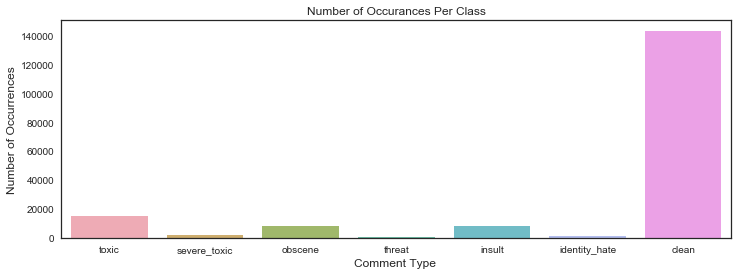

In [10]:
x = temp_data[labels].sum()
plt.figure(figsize=(12,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Number of Occurances Per Class")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Comment Type ', fontsize=12)

x

We see that the `toxic` comment is the most common of the toxicity comment types. From looking at the head of the comments we see that a comment can be classed as one or more of the toxicity comment types. Therefore, we should look to identify any correlations one comment type would have with others. Since our data is categorical we'll want to 

In [11]:
# TODO: Confusion matrix

It is also worth exlporing the frequency of certain words that appear in each of toxicity columns as well as the clean column. To visualise the word frequency we'll use word cloud diagrams for each category.

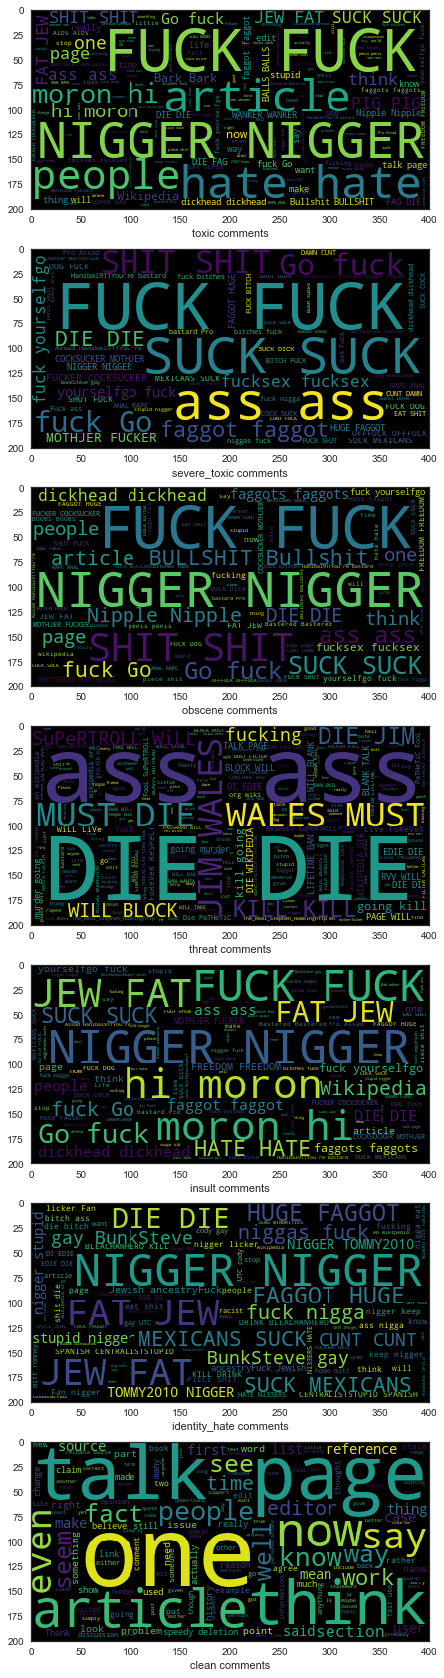

In [20]:
def concat_strings(label):
    string_io = StringIO() 
    comments = temp_data[temp_data[label] == 1].comment_text
    comments.apply(lambda x: string_io.write(str(x)))
    text = string_io.getvalue()
    string_io.close()
    return text

fig = plt.figure(figsize=(20,30))

for i, label in enumerate(labels):
    text = concat_strings(label)
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(max_words=len(text), relative_scaling=.5).generate(text)
    fig.add_subplot(7, 1, i + 1)
    plt.imshow(wordcloud)
    plt.xlabel("{} comments".format(label))


plt.show()
    

## Data Preprcessing 
Now that we've performed our data analysis we'll begin our work on preporcessing the data. We want to apply several methods for preprocessing our data. The first method is to use the bag of words technique and (word frequency). Then we want to use Word2Vec and GloVe. Below we will define several functions that will take in the raw comments and preprocess them.

### Pre Processing Steps
The first preprocessing step we'll take is to clean the text before processing it into vectors.

In [35]:
data.loc[50, 'comment_text'][:500]

'"\n\nBI, you said you wanted to talk\n\nAt the bottom of the lead section you have written:\n\n""Its promoter speculated in 1994 that the skyhook concept could be cost competitive with what is realistically thought to be achievable using a space elevator, but the skyhook is not competitive with other rotating tether concepts. In addition, the rotating skyhook is in fact deemed ""not engineeringly feasible using presently available materials"".""\n\nRegarding:  In addition, the rotating skyhook is in fac'

As we can see above, some of the comments contain escapped characters, punctuation, and other non-alphanumeric characters. Our inital preprocessing step is to remove all non alphabetical characters. By removing the escaped characters we'll be able to make the text cleaner. However, by removing some of the punctuation we could loose some semantic information. Particularly if we have a user quoting another user's comment or wikipedia that has unsavory text in it.

In [134]:
import re
def text_preprocessor(text : str)-> str:
    regex = r"(\n|\t|\d|[^\s\w])+"
    partially_processed_text = re.sub(regex, ' ', text.lower(), 0, re.MULTILINE)
    return re.sub(r" +",' ', partially_processed_text).strip()

# result = re.sub(regex, subst, test_str, 0, re.MULTILINE)

print(type(data.loc[50, 'comment_text']))
text_preprocessor(data.loc[50, 'comment_text'][:500])


<class 'str'>


'bi you said you wanted to talk at the bottom of the lead section you have written its promoter speculated in that the skyhook concept could be cost competitive with what is realistically thought to be achievable using a space elevator but the skyhook is not competitive with other rotating tether concepts in addition the rotating skyhook is in fact deemed not engineeringly feasible using presently available materials regarding in addition the rotating skyhook is in fac'

In [138]:
data['comment_text'] = data['comment_text'].apply(text_preprocessor)

data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,d aww he matches this background colour i m se...,0,0,0,0,0,0,True
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,more i can t make any real suggestions on impr...,0,0,0,0,0,0,True
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,True


As we can now see in the table above we've removed punctuations and escaped characters. We also converted the text to lower case.